In [188]:
from tqdm.notebook import tqdm
# importing required libraries
import pymysql
import pymysql.cursors
import xlsxwriter
import pandas as pd
import json
import sys
# setting path
sys.path.append('../PYTHON_SCRIPTS')
import normalize_nodes
import matplotlib

dataBase = pymysql.connect(
  host ="localhost",
  user ="root",
  passwd = "password",
  cursorclass=pymysql.cursors.DictCursor
)
 
# preparing a cursor object
mycursor = dataBase.cursor()

# Index in Array where to place the score of each ARA
# Index + 1 will store the normalized score of the ARA
# Index 0 will store Disease
# Index 1 will store Drug
ara_indexing = {
            "arax"                :  2,
            "explanatory_agent"   :  4,
            "ia"                  :  6,
            "unsecret_agent"      :  8,
            "aragorn"             :  10,
            "robokop"             :  12,
            "bte"                 :  14
             }


### Function to get ARA Provider

In [2]:
def get_ara_provider(row):
    """
    Function that returns the ARA a query was sent to
    Will return None if no ARA could be tagged to the query
    """
    if "message" not in row['data']:
        return
    message = row['data']['message']
    if 'results' not in message:
        return

    elif not message['results']:
        return

    elif "reasoner_id" in message['results'][0]:
        if message['results'][0]["reasoner_id"] == "ARAX":
            return "arax"
        elif message['results'][0]["reasoner_id"] == "Explanatory Agent":
            return "explanatory_agent"

    edges = message["knowledge_graph"]["edges"]
    key = list(edges.keys())[0]
    attribute_list = edges[key]['attributes']
    for attribute in attribute_list:
        if 'value' not in attribute:
            continue
        label = attribute['value']
        if isinstance(label, str):
            if label == "infores:openpredict":
                return "op"
            elif label == "infores:improving-agent":
                return "ia"
            elif label == "infores:molepro":
                return "molepro"
            elif label == "infores:unsecret-agent":
                return "unsecret_agent"
            elif label == "infores:genetics-data-provider":
                return "geneticskp"
            elif label == "infores:aragorn" in label:
                return "aragorn"
        elif isinstance(label, list):
            if "infores:biothings-explorer" in label:
                return "bte"
            elif "infores:automat-robokop" in label:
                return "robokop"
    #Print ids of queries which weren't tagged to any  ARA 
    print(row['id'])

### Function to fetch score from results and place in output_data Dictionary

In [79]:
def score_parser(json_data,ara):
    query_node = json_data['data']['message']['query_graph']['nodes']
    if 'on' in query_node:
        disease_idx = query_node['on']['ids'][0]
    elif 'n0' in query_node:
        disease_idx = query_node['n0']['ids'][0]
    elif 'disease' in query_node:
        disease_idx = query_node['disease']['ids'][0]
    else:
        print(query_node)
        raise Exception("Could not get Disease")
            
    if disease_idx not in output_data:
        output_data[disease_idx] = dict()
    for result in json_data['data']['message']['results']:
        node_bindings = result['node_bindings']
        if 'sn' in node_bindings:
            drug_idx = node_bindings['sn'][0]['id']
        elif 'n1' in node_bindings:
            drug_idx = node_bindings['n1'][0]['id']
        elif 'drug' in node_bindings:
            drug_idx = node_bindings['drug'][0]['id']
        elif "chemical" in node_bindings:
            drug_idx = node_bindings['chemical'][0]['id']
        else:
            print(node_bindings)
            raise Exception("Could not get Drug")
            
        if drug_idx not in output_data[disease_idx]:
            output_data[disease_idx][drug_idx] = [disease_idx, drug_idx, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        
        #Noticed some Aragorn queries did not have scores in the results
        if 'score' not in result:
            return "error"
        score = result['score']
        if 'normalized_score' in result:
            normalized_score = result['normalized_score']
        else:
            normalized_score = 0
        output_data[disease_idx][drug_idx][ara_indexing[ara]] = score
        output_data[disease_idx][drug_idx][ara_indexing[ara] + 1] = normalized_score
    return "success"

In [26]:
def convert_to_dataframe(data):
    final_output = []
    for disease, drugs in data.items():
        for drug,values in drugs.items():
            final_output.append(values)

    return final_output

In [27]:
def write_to_excel(data):
    headers = ["Disease", "Drug", "ARAX", "ARAX NS", "EA", "EA NS", "IA", "IA NS", "UA", "UA NS",
                "AR", "AR NS","ROBO", "ROBO NS", "BTE", "BTE NS"]
    writer = pd.ExcelWriter('results.xlsx', engine='xlsxwriter')
    data.to_excel(writer, sheet_name='Sheet1', header=headers, index=False)
    writer.save()


## Score Parser

In [97]:
def score_parser(json_data,ara):
    query_node = json_data['data']['message']['query_graph']['nodes']
    if 'on' in query_node:
        #Weird gene query
        if query_node['on'].get('categories',[]) == ['biolink:Gene']:
            return
        if('ids' in query_node['on']):
            disease_idx = query_node['on']['ids'][0]
    elif 'n0' in query_node:
        disease_idx = query_node['n0']['ids'][0]
    elif 'disease' in query_node:
        disease_idx = query_node['disease']['ids'][0]
    else:
        print(query_node)
        raise Exception("Could not get Disease")
            
    if disease_idx not in output_data:
        output_data[disease_idx] = dict()
    for result in json_data['data']['message']['results']:
        node_bindings = result['node_bindings']
        if 'sn' in node_bindings:
            drug_idx = node_bindings['sn'][0]['id']
        elif 'n1' in node_bindings:
            drug_idx = node_bindings['n1'][0]['id']
        elif 'drug' in node_bindings:
            drug_idx = node_bindings['drug'][0]['id']
        elif "chemical" in node_bindings:
            drug_idx = node_bindings['chemical'][0]['id']
        else:
            print(node_bindings)
            raise Exception("Could not get Drug")
            
        if drug_idx not in output_data[disease_idx]:
            output_data[disease_idx][drug_idx] = [disease_idx, drug_idx, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        
        #Noticed some Aragorn queries did not have scores in the results
        if 'score' not in result:
            return "error"
        score = result['score']
        if 'normalized_score' in result:
            normalized_score = result['normalized_score']
        else:
            normalized_score = 0
        output_data[disease_idx][drug_idx][ara_indexing[ara]] = score
        output_data[disease_idx][drug_idx][ara_indexing[ara] + 1] = normalized_score
    return "success"

In [98]:
#ars_data
#table  ('tr_ars_message',)
lower_limit = 0
upper_limit = 100
increment = 100
myresult = [1]
output_data = dict()
# while lower_limit == 0 or myresult:
dataBase = pymysql.connect(
  host ="localhost",
  user ="root",
  passwd = "password",
  cursorclass=pymysql.cursors.DictCursor
)
mycursor = dataBase.cursor()

mycursor.execute(f"SELECT COUNT(*) FROM ars_dump_2.tr_ars_message")
total_rows = mycursor.fetchone()['COUNT(*)']

# preparing a cursor object
mycursor = dataBase.cursor()
query = f"SELECT data,id FROM ars_dump_2.tr_ars_message LIMIT 100 OFFSET %s"
print(query)
mycursor.execute(query, (0))

#row = mycursor.fetchone()
cnt = 0

def handleRow(x):
    data = x['data']
    idx = x['id']
    for i in range(1):
#    try:
        x["data"] = json.loads(data)
        if 'message' not in j:
            return
        if "biolink:treats" not in str(j['message']['query_graph']):
            return
            
        ara = get_ara_provider(x)
        if ara not in list(ara_indexing.keys()):
            return
        if "aragorn" == ara:
            return
        score_parser(x,ara)
#    except Exception as err:
#        print(f"ID: {idx} Unexpected {err=}, {type(err)=}")
    return
print(cnt)
#for offset in range(0,total_rows,100):
for offset in tqdm(range(0,total_rows,100)):
    mycursor.execute(query, (offset))
    row = mycursor.fetchone()
    while row is not None:
        if(cnt%10==0):print(cnt)
        cnt+=1
        handleRow(row)
        

        row = mycursor.fetchone()
               
        

SELECT data,id FROM ars_dump_2.tr_ars_message LIMIT 100 OFFSET %s
0


  0%|          | 0/38 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [96]:
row['data']
row['data']['message']['query_graph']['nodes']

{'on': {'ids': None,
  'is_set': False,
  'categories': ['biolink:Gene'],
  'constraints': [],
  'option_group_id': None},
 'sn': {'ids': ['PUBCHEM.COMPOUND:3496'],
  'is_set': False,
  'categories': ['biolink:ChemicalEntity'],
  'constraints': [],
  'option_group_id': None}}

In [91]:
row['data']['message']['query_graph']['nodes']['on']['categories'] == ['biolink:Gene']

True

In [88]:
row['data']['message']

{'results': [{'score': 1.0163650995361615,
   'edge_bindings': {'s15': [{'id': '70240370-f427-4f57-93fa-f9a64e86042c',
      'attributes': [{'value': 0.03308968574213478,
        'attributes': [{'value': 'infores:omnicorp',
          'value_type_id': 'biolink:InformationResource',
          'attribute_type_id': 'biolink:has_qualitative_value',
          'original_attribute_name': 'aragorn_weight_source'}],
        'value_type_id': 'EDAM:data_1669',
        'attribute_type_id': 'biolink:has_numeric_value',
        'original_attribute_name': 'weight'}]}],
    '_dummy_edge_0': [{'id': '58219092',
      'attributes': [{'value': 0.964709731465073,
        'attributes': [{'value': 'infores:ctd',
          'value_type_id': 'biolink:InformationResource',
          'attribute_type_id': 'biolink:has_qualitative_value',
          'original_attribute_name': 'aragorn_weight_source'}],
        'value_type_id': 'EDAM:data_1669',
        'attribute_type_id': 'biolink:has_numeric_value',
        'origi

In [66]:
print(list())
print(total_rows)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700]
3798


In [117]:
diseases = list(set(a[0] for a in y))
drugs = list(set(a[1] for a in y))

disease_dict = normalize_nodes.normalize_big_list(diseases)
drug_dict = normalize_nodes.normalize_big_list(drugs)

z = []
for a in y:
    dis = disease_dict.get(a[0],None)
    if(dis==None):dis=a[1]
        
    drug = drug_dict.get(a[1],None)
    if(drug==None):drug=a[1]
        
    z.append([dis,drug] + a[2:])

In [120]:
z = []
for a in y:
    dis = disease_dict.get(a[0],None)
    if(dis==None):dis=a[1]
    else:dis=dis[0]
        
    drug = drug_dict.get(a[1],None)
    if(drug==None):drug=a[1]
    else:drug=drug[0]
        
    z.append([dis,drug] + a[2:])

In [121]:
z[0]

['MONDO:0005147',
 'PUBCHEM.COMPOUND:1123',
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.7960855981850602,
 100.0,
 0.8339210298367046,
 1.6]

In [102]:
y = convert_to_dataframe(output_data)
df = pd.DataFrame(y)
df

cols = ['Disease','Drug', 'ARAX', 'ARAX NS', 'EA', 'EA NS', 'IA', 'IA NS', 'UA', 'UA NS', 'AR', 'AR NS', 'ROBO','ROBO NS', 'BTE', 'BTE NS']

df.columns = cols
df

,Disease,Drug,ARAX,ARAX NS,EA,EA NS,IA,IA NS,UA,UA NS,AR,AR NS,ROBO,ROBO NS,BTE,BTE NS
0,MONDO:0005147,PUBCHEM.COMPOUND:1123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.796086,100.000000,0.833921,1.6
1,MONDO:0005147,DRUGBANK:DB11293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
2,MONDO:0005147,MESH:D000073878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
3,MONDO:0005147,UMLS:C1957777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
4,MONDO:0005147,PUBCHEM.COMPOUND:123596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56301,MONDO:0031376,MESH:D004100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.558714,1.0
56302,MONDO:0031376,PUBCHEM.COMPOUND:4507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.558549,0.8
56303,MONDO:0031376,PUBCHEM.COMPOUND:936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.551507,0.6
56304,MONDO:0031376,UMLS:C0003419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.545403,0.4


In [122]:
df = pd.DataFrame(z)
df

cols = ['Disease','Drug', 'ARAX', 'ARAX NS', 'EA', 'EA NS', 'IA', 'IA NS', 'UA', 'UA NS', 'AR', 'AR NS', 'ROBO','ROBO NS', 'BTE', 'BTE NS']

df.columns = cols
df

,Disease,Drug,ARAX,ARAX NS,EA,EA NS,IA,IA NS,UA,UA NS,AR,AR NS,ROBO,ROBO NS,BTE,BTE NS
0,MONDO:0005147,PUBCHEM.COMPOUND:1123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.796086,100.000000,0.833921,1.6
1,MONDO:0005147,DRUGBANK:DB11293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
2,MONDO:0005147,UNII:5QUO05548Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
3,MONDO:0005147,MESH:C520506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
4,MONDO:0005147,PUBCHEM.COMPOUND:123596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56301,MONDO:0031376,MESH:D004100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.558714,1.0
56302,MONDO:0031376,PUBCHEM.COMPOUND:4507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.558549,0.8
56303,MONDO:0031376,PUBCHEM.COMPOUND:936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.551507,0.6
56304,MONDO:0031376,UMLS:C0003419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.545403,0.4


In [123]:
df = normalize_nodes.normalize_data_frame(df,"Disease")
df

,Disease,Disease_normalized_idx,Disease_normalized_name,Drug,ARAX,ARAX NS,EA,EA NS,IA,IA NS,UA,UA NS,AR,AR NS,ROBO,ROBO NS,BTE,BTE NS
0,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,PUBCHEM.COMPOUND:1123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.796086,100.000000,0.833921,1.6
1,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,DRUGBANK:DB11293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
2,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,UNII:5QUO05548Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
3,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,MESH:C520506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
4,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,PUBCHEM.COMPOUND:123596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56301,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,MESH:D004100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.558714,1.0
56302,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,PUBCHEM.COMPOUND:4507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.558549,0.8
56303,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,PUBCHEM.COMPOUND:936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.551507,0.6
56304,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,UMLS:C0003419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.545403,0.4


In [124]:
df = normalize_nodes.normalize_data_frame(df,"Drug")
df

/home/ubuntu/NCATS/../PYTHON_SCRIPTS/normalize_nodes.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[idx_col] = df.apply(lambdaFunc,index=0, key=key, axis=1)
/home/ubuntu/NCATS/../PYTHON_SCRIPTS/normalize_nodes.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name_col] = df.apply(lambdaFunc,index=1, key=key, axis=1)


,Disease,Disease_normalized_idx,Disease_normalized_name,Drug,Drug_normalized_idx,Drug_normalized_name,ARAX,ARAX NS,EA,EA NS,IA,IA NS,UA,UA NS,AR,AR NS,ROBO,ROBO NS,BTE,BTE NS
0,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,PUBCHEM.COMPOUND:1123,PUBCHEM.COMPOUND:1123,Taurine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.796086,100.000000,0.833921,1.6
1,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,DRUGBANK:DB11293,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
2,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,UNII:5QUO05548Z,UNII:5QUO05548Z,PALM OIL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
3,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,MESH:C520506,MESH:C520506,manganese tetrakis-(N-ethyl-2 pyridyl) porphyrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
4,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,PUBCHEM.COMPOUND:123596,PUBCHEM.COMPOUND:123596,Imatinib Mesylate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56301,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,MESH:D004100,MESH:D004100,Dihydroxycholecalciferols,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.558714,1.0
56302,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,PUBCHEM.COMPOUND:4507,PUBCHEM.COMPOUND:4507,Nitrendipine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.558549,0.8
56303,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,PUBCHEM.COMPOUND:936,PUBCHEM.COMPOUND:936,Nicotinamide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.551507,0.6
56304,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,UMLS:C0003419,UMLS:C0003419,Antipyretics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.545403,0.4


In [129]:
df.drop("Non-zero hits", axis=1)
normal_cols = df.columns.str.contains("NS")
df.columns[normal_cols].tolist()
#df[normal_cols]
#df["C"] = df[["A", "B"]].max(axis=1)
df["Non-zero hits"] = df[df.columns[normal_cols].tolist()].applymap(lambda x: x>0).sum(axis=1)

normal_cols = df.columns.str.contains("NS")

df["Max Normalized Score"] = df[df.columns[normal_cols].tolist()].max(axis=1)

#normal_cols = df_org.columns.str.contains("NS")
df["Max Source"] = df[df.columns[normal_cols].tolist()].idxmax(axis=1)
df.loc[df['Max Normalized Score'] == 0, 'Max Source'] = "N/A"

/tmp/ipykernel_119297/1905397534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Non-zero hits"] = df[df.columns[normal_cols].tolist()].applymap(lambda x: x>0).sum(axis=1)
/tmp/ipykernel_119297/1905397534.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Max Normalized Score"] = df[df.columns[normal_cols].tolist()].max(axis=1)
/tmp/ipykernel_119297/1905397534.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [134]:
df

,Disease,Disease_normalized_idx,Disease_normalized_name,Drug,Drug_normalized_idx,Drug_normalized_name,ARAX,ARAX NS,EA,EA NS,...,UA NS,AR,AR NS,ROBO,ROBO NS,BTE,BTE NS,Non-zero hits,Max Normalized Score,Max Source
0,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,PUBCHEM.COMPOUND:1123,PUBCHEM.COMPOUND:1123,Taurine,0.0,0.0,0.0,0.0,...,0.0,0,0,0.796086,100.000000,0.833921,1.6,2,100.000000,ROBO NS
1,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,DRUGBANK:DB11293,None,None,0.0,0.0,0.0,0.0,...,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451,ROBO NS
2,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,UNII:5QUO05548Z,UNII:5QUO05548Z,PALM OIL,0.0,0.0,0.0,0.0,...,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451,ROBO NS
3,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,MESH:C520506,MESH:C520506,manganese tetrakis-(N-ethyl-2 pyridyl) porphyrin,0.0,0.0,0.0,0.0,...,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451,ROBO NS
4,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,PUBCHEM.COMPOUND:123596,PUBCHEM.COMPOUND:123596,Imatinib Mesylate,0.0,0.0,0.0,0.0,...,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451,ROBO NS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56301,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,MESH:D004100,MESH:D004100,Dihydroxycholecalciferols,0.0,0.0,0.0,0.0,...,0.0,0,0,0.000000,0.000000,3.558714,1.0,1,1.000000,BTE NS
56302,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,PUBCHEM.COMPOUND:4507,PUBCHEM.COMPOUND:4507,Nitrendipine,0.0,0.0,0.0,0.0,...,0.0,0,0,0.000000,0.000000,3.558549,0.8,1,0.800000,BTE NS
56303,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,PUBCHEM.COMPOUND:936,PUBCHEM.COMPOUND:936,Nicotinamide,0.0,0.0,0.0,0.0,...,0.0,0,0,0.000000,0.000000,3.551507,0.6,1,0.600000,BTE NS
56304,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,UMLS:C0003419,UMLS:C0003419,Antipyretics,0.0,0.0,0.0,0.0,...,0.0,0,0,0.000000,0.000000,3.545403,0.4,1,0.400000,BTE NS


In [135]:
df.to_excel("normalized_ars_0407_results.xlsx")


ModuleNotFoundError: No module named 'matplotlib'

In [9]:
y = convert_to_dataframe(output_data)
df = pd.DataFrame(y)
df
write_to_excel(df)

/var/folders/yq/h_8tpsgn7mg08_j54v167d_r0000gn/T/ipykernel_83467/2974622994.py:6: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [10]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,MONDO:0008436,UMLS:C0243192,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0,0,0.0,0.0,0.0,0.0
1,MONDO:0008436,PUBCHEM.COMPOUND:1032,0.0,0.0,0.0,0.0,0.0,0.0,0.961538,0.0,0,0,0.0,0.0,0.0,0.0
2,MONDO:0008436,MESH:D008055,0.0,0.0,0.0,0.0,0.0,0.0,0.923077,0.0,0,0,0.0,0.0,0.0,0.0
3,MONDO:0008436,PUBCHEM.COMPOUND:449171,0.0,0.0,0.0,0.0,0.0,0.0,0.884615,0.0,0,0,0.0,0.0,0.0,0.0
4,MONDO:0008436,UMLS:C0242947,0.0,0.0,0.0,0.0,0.0,0.0,0.846154,0.0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48553,MONDO:0100062,PUBCHEM.COMPOUND:5761,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0,0,0.0,0.0,1.6,1.1
48554,MONDO:0100062,PUBCHEM.COMPOUND:923,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0,0,0.0,0.0,1.6,1.1
48555,MONDO:0100062,PUBCHEM.COMPOUND:124886,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0,0,0.0,0.0,1.6,1.1
48556,MONDO:0100062,PUBCHEM.COMPOUND:33032,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0,0,0.0,0.0,1.6,1.1


In [137]:
df

,Disease,Disease_normalized_idx,Disease_normalized_name,Drug,Drug_normalized_idx,Drug_normalized_name,ARAX,ARAX NS,EA,EA NS,...,UA NS,AR,AR NS,ROBO,ROBO NS,BTE,BTE NS,Non-zero hits,Max Normalized Score,Max Source
0,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,PUBCHEM.COMPOUND:1123,PUBCHEM.COMPOUND:1123,Taurine,0.0,0.0,0.0,0.0,...,0.0,0,0,0.796086,100.000000,0.833921,1.6,2,100.000000,ROBO NS
1,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,DRUGBANK:DB11293,None,None,0.0,0.0,0.0,0.0,...,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451,ROBO NS
2,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,UNII:5QUO05548Z,UNII:5QUO05548Z,PALM OIL,0.0,0.0,0.0,0.0,...,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451,ROBO NS
3,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,MESH:C520506,MESH:C520506,manganese tetrakis-(N-ethyl-2 pyridyl) porphyrin,0.0,0.0,0.0,0.0,...,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451,ROBO NS
4,MONDO:0005147,MONDO:0005147,type 1 diabetes mellitus,PUBCHEM.COMPOUND:123596,PUBCHEM.COMPOUND:123596,Imatinib Mesylate,0.0,0.0,0.0,0.0,...,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451,ROBO NS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56301,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,MESH:D004100,MESH:D004100,Dihydroxycholecalciferols,0.0,0.0,0.0,0.0,...,0.0,0,0,0.000000,0.000000,3.558714,1.0,1,1.000000,BTE NS
56302,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,PUBCHEM.COMPOUND:4507,PUBCHEM.COMPOUND:4507,Nitrendipine,0.0,0.0,0.0,0.0,...,0.0,0,0,0.000000,0.000000,3.558549,0.8,1,0.800000,BTE NS
56303,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,PUBCHEM.COMPOUND:936,PUBCHEM.COMPOUND:936,Nicotinamide,0.0,0.0,0.0,0.0,...,0.0,0,0,0.000000,0.000000,3.551507,0.6,1,0.600000,BTE NS
56304,MONDO:0031376,MONDO:0031376,congenital disorder of deglycosylation,UMLS:C0003419,UMLS:C0003419,Antipyretics,0.0,0.0,0.0,0.0,...,0.0,0,0,0.000000,0.000000,3.545403,0.4,1,0.400000,BTE NS


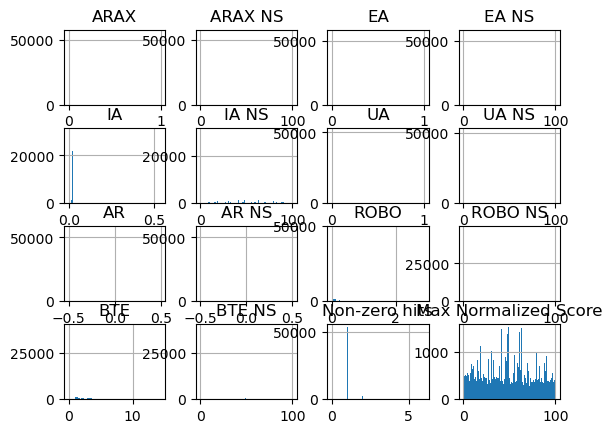

In [140]:
hist = df.hist(bins=100)

<IPython.core.display.Javascript object>


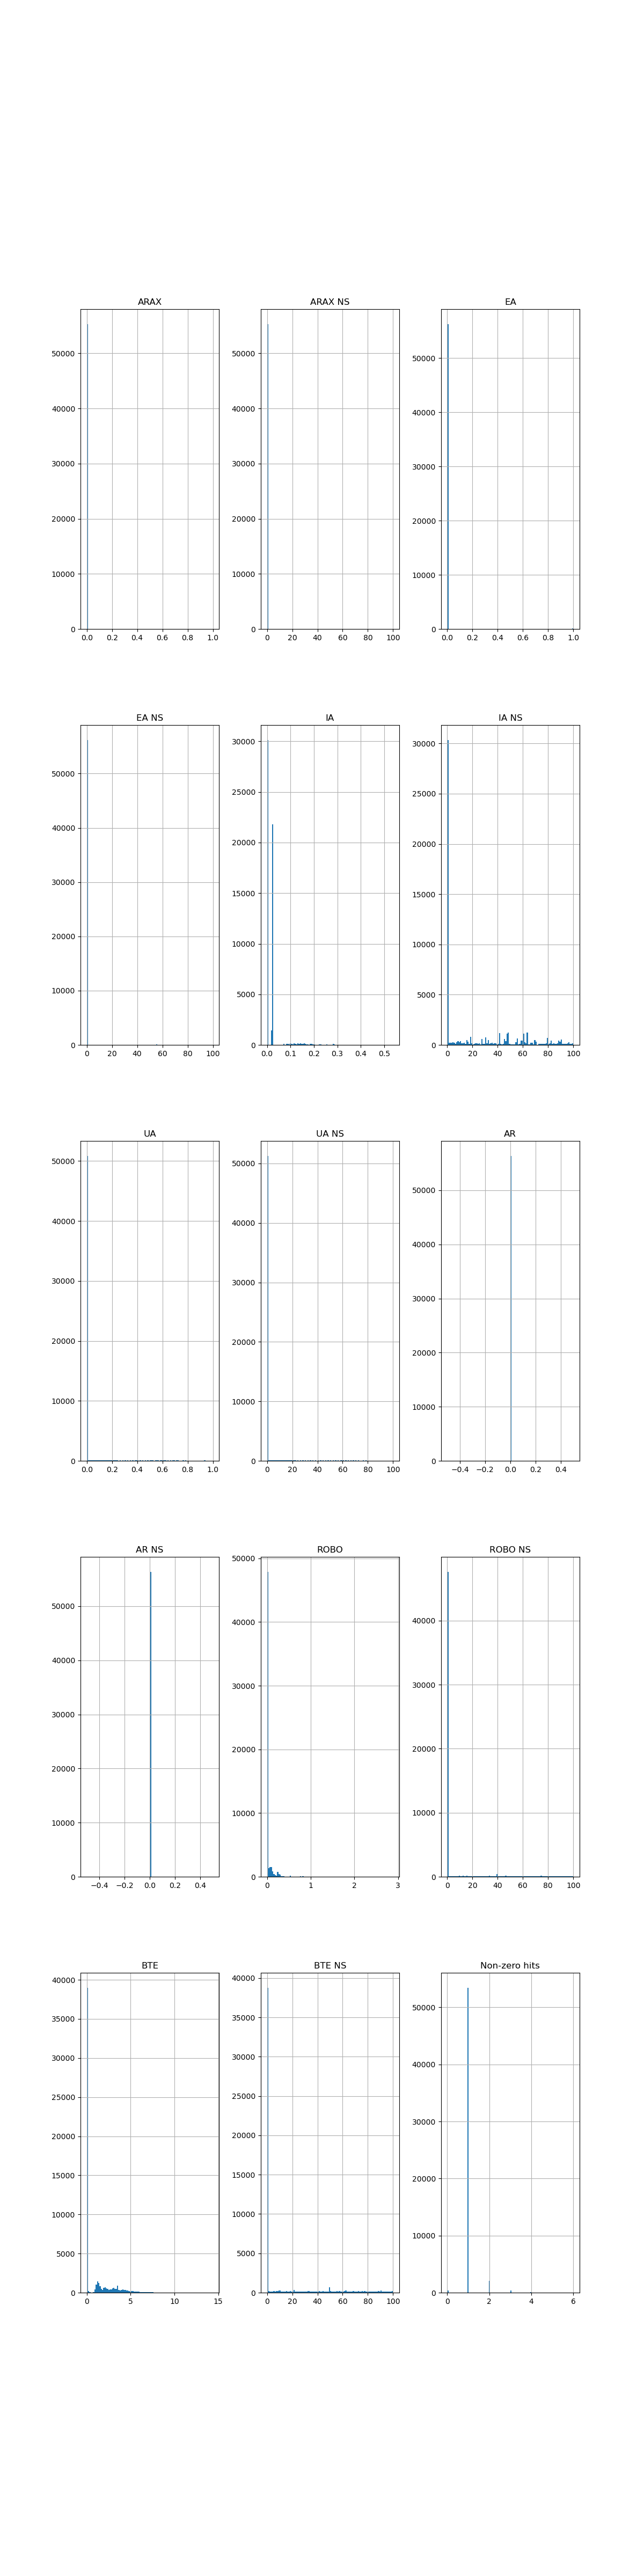

In [186]:
%matplotlib notebook
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = df.select_dtypes(include=numerics)
from itertools import combinations
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(newdf.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        newdf.hist(column = newdf.columns[i], bins = 100, ax=axis)
        i = i+1

<IPython.core.display.Javascript object>


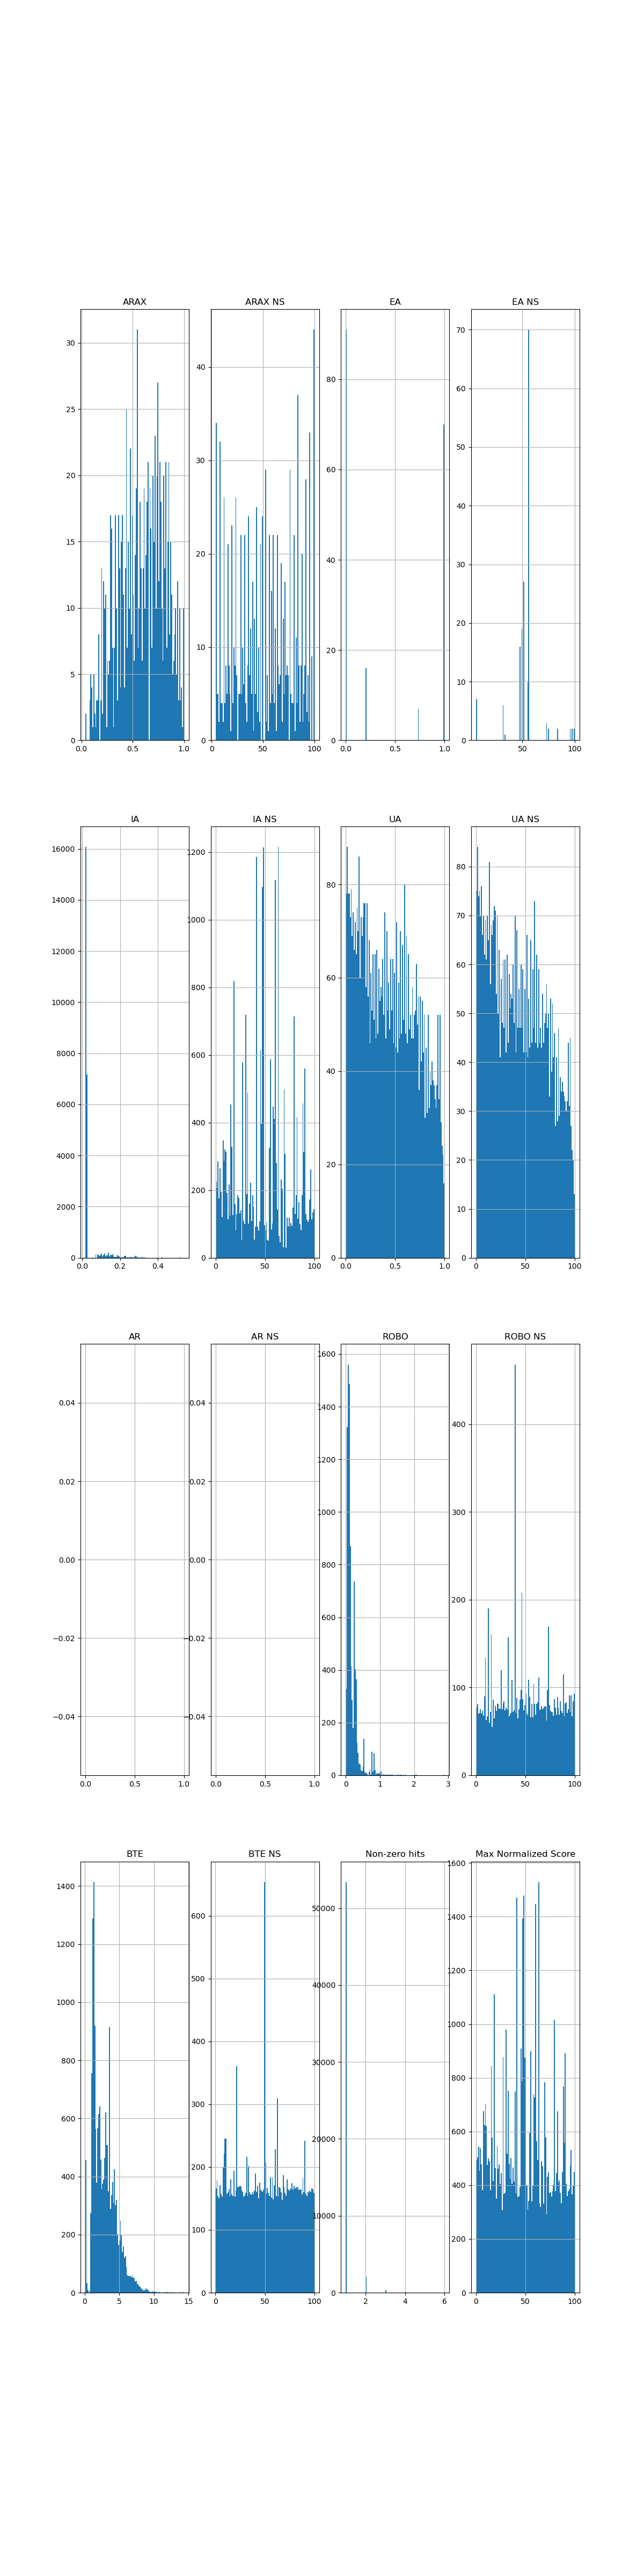

In [187]:

from itertools import combinations
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(newdf.columns)//4, 4, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
#        col_name = newdf.columns[i]
        non_zero = newdf[newdf.columns[i]] [ newdf[newdf.columns[i]] > 0 ]
        #axis.hist(non_zero, color="grey", bins=100, ax=axis)
        non_zero.hist( bins = 100, ax=axis)
        axis.set_title(newdf.columns[i])
        i = i+1
        


<IPython.core.display.Javascript object>


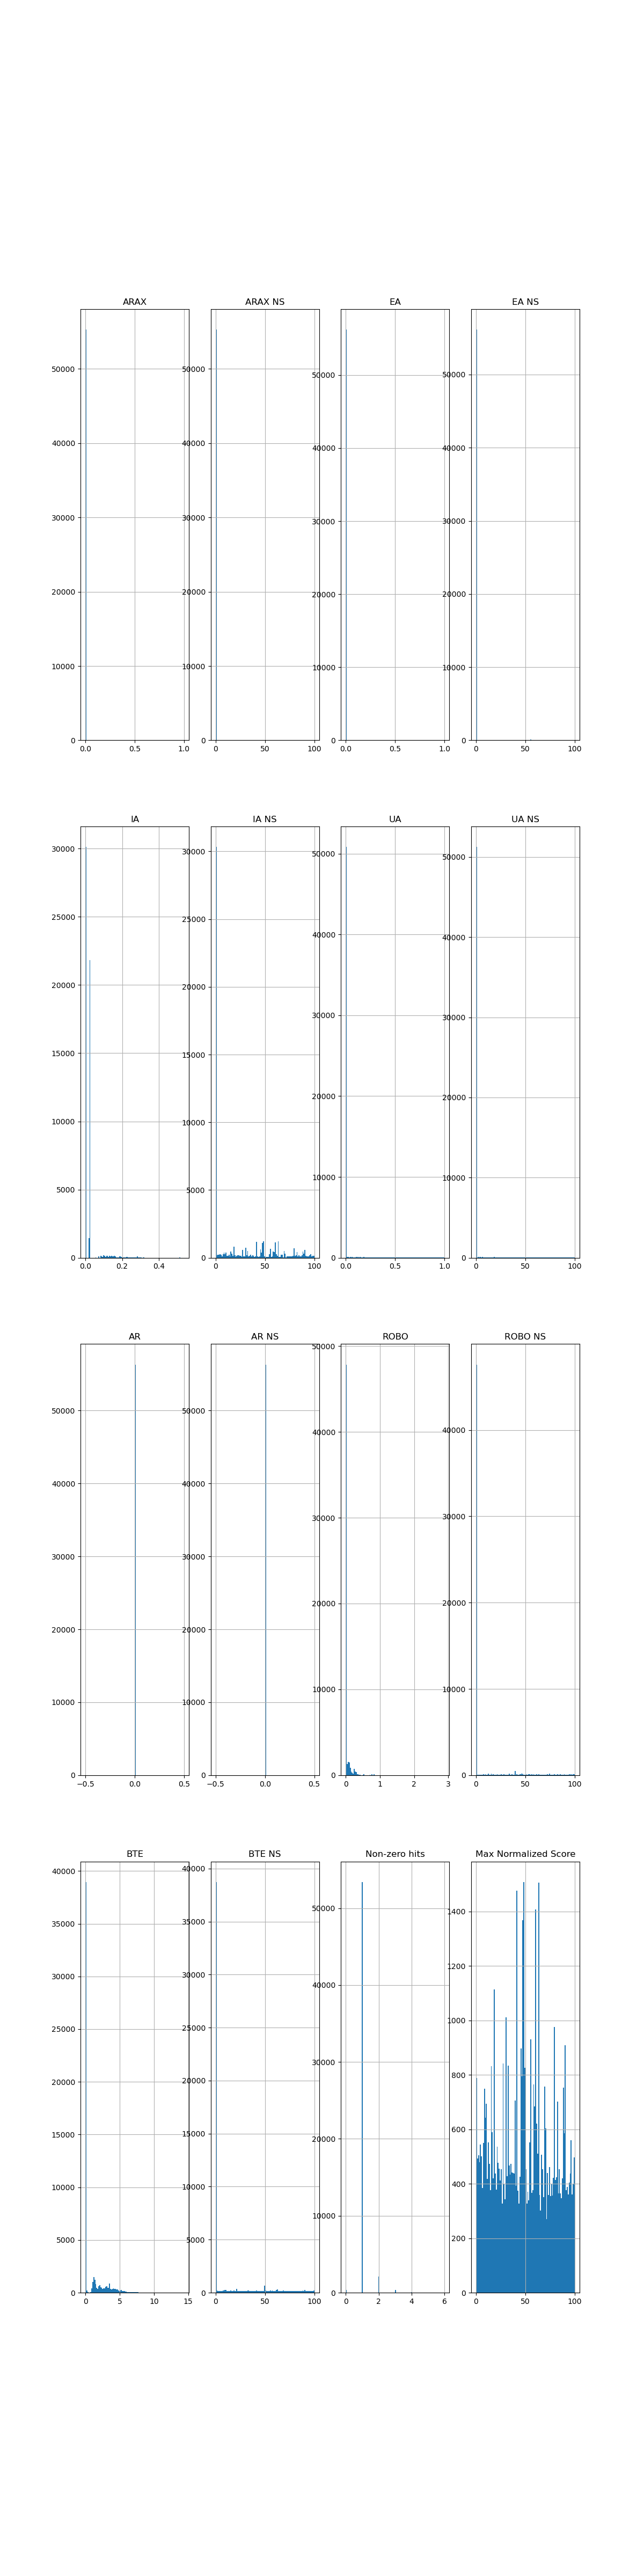

In [184]:
fig, axes = plt.subplots(len(newdf.columns)//4, 4, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
#        col_name = newdf.columns[i]
        with_zero = newdf[newdf.columns[i]] [ newdf[newdf.columns[i]] >= 0 ]
        #axis.hist(non_zero, color="grey", bins=100, ax=axis)
        with_zero.hist( bins = 100, ax=axis)
        axis.set_title(newdf.columns[i])
        i = i+1

In [182]:
fig.savefig('with-zero.png')

In [147]:
plt.hist(Beam_irradiance_DNI[Beam_irradiance_DNI != 0], color="grey")

,ARAX,ARAX NS,EA,EA NS,IA,IA NS,UA,UA NS,AR,AR NS,ROBO,ROBO NS,BTE,BTE NS,Non-zero hits,Max Normalized Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.796086,100.000000,0.833921,1.6,2,100.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.767949,98.627451,0.000000,0.0,1,98.627451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.558714,1.0,1,1.000000
56302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.558549,0.8,1,0.800000
56303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.551507,0.6,1,0.600000
56304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000,3.545403,0.4,1,0.400000


In [154]:
newdf[newdf.columns[2]] [ newdf[newdf.columns[2]] > 0 ]

2351     0.2001
2353     0.0001
2354     0.2001
4101     0.0001
4103     0.2001
          ...  
52677    0.0001
52703    0.0001
52711    0.0001
52742    0.0001
52747    0.0001
Name: EA, Length: 184, dtype: float64

In [164]:
plt.hist(a, 100, density = True, 
         histtype ='bar')
#plt.legend(prop ={'size': 10})
plt.show()

In [162]:
a = newdf[newdf.columns[2]] [ newdf[newdf.columns[2]] > 0 ].values

In [166]:
plt.show()

<IPython.core.display.Javascript object>


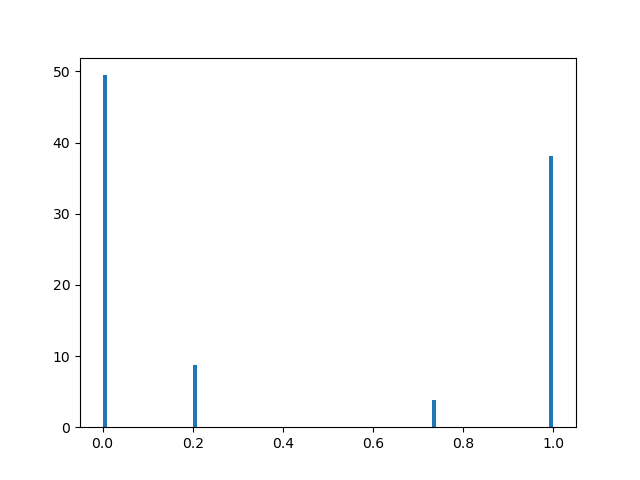

(array([49.46146789,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         8.69652183,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [169]:
fig = plt.figure()
ax = fig.gca()
ax.hist(a,100,density=True,histtype='bar')

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


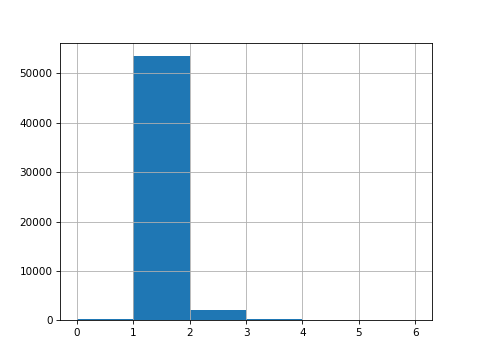

<AxesSubplot: >

In [194]:
%matplotlib
df["Non-zero hits"].hist(bins=6)

In [190]:
df.columns

Index(['Disease', 'Disease_normalized_idx', 'Disease_normalized_name', 'Drug',
       'Drug_normalized_idx', 'Drug_normalized_name', 'ARAX', 'ARAX NS', 'EA',
       'EA NS', 'IA', 'IA NS', 'UA', 'UA NS', 'AR', 'AR NS', 'ROBO', 'ROBO NS',
       'BTE', 'BTE NS', 'Non-zero hits', 'Max Normalized Score', 'Max Source'],
      dtype='object')

<IPython.core.display.Javascript object>


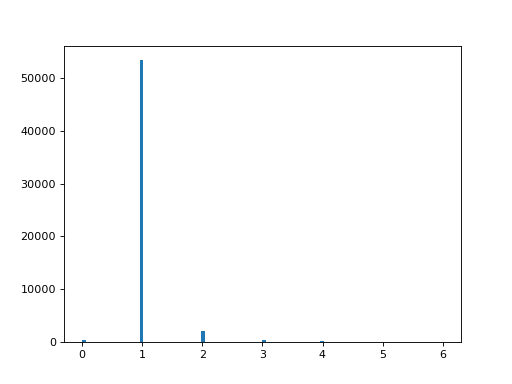

(array([3.5800e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.3402e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.1020e+03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.6200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.8000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

In [196]:
fig = plt.figure()
ax = fig.gca()
ax.hist(list(df["Non-zero hits"]),100,density=False,histtype='bar')